# Stock price prediction using RNN and LSTM

Dataset source: [Kaggle](https://www.kaggle.com/datasets/medharawat/google-stock-price)

- In the simplest terms, **time-series forecasting** is a technique that utilizes historical and current data to predict future values over a period of time or a specific point in the future. 
- In this example we are going to do time series forecasting of Stock prices of Google Inc.
- Time series forecasting can be framed as a supervised learning problem.
- This re-framing of time series data allows you access to the suite of standard linear and nonlinear machine learning algorithms on the problem statement.

Read more here: [Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)

In [1]:
# Uncomment and run following lines, if you are training model on GPUs

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# Data Review

Read the dataset with the pandas library

In [3]:
data = pd.read_csv("../data/Google_Stock_Price_Train.csv")

In [4]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [5]:
# information of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [6]:
# Dataset Values(Max, min, std..)
data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [7]:
# Data Correlation: Relationship between columns
data.corr()

C:\Users\naine\AppData\Local\Temp\ipykernel_17344\3592020041.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,Open,High,Low
Open,1.000000,0.999692,0.999498
High,0.999692,1.000000,0.999480
Low,0.999498,0.999480,1.000000


C:\Users\naine\AppData\Local\Temp\ipykernel_17344\1238401946.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)


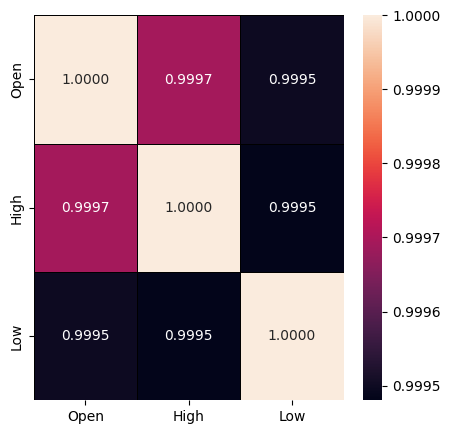

In [8]:
# Visualization of correlation result with seaborn library heatmap.
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data.corr(), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

In the above section, look at the relationship between columns of type float64.

In [9]:
# Dataset columns names
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

# Data Preparation

## Select the Columns on which we will apply the RNN

In [10]:
data_set = data.loc[:, ["Open"]].values

In [11]:
data_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

## Seperate train and test data

In [12]:
data_set.shape

(1258, 1)

In [13]:
# take last 50 values for testing
train = data_set[:len(data_set) - 50]
test = data_set[len(train):]

In [14]:
train.reshape(train.shape[0],1)
train.shape

(1208, 1)

## Normalize the train dataset (between zero to one)
- Using the MinMaxScaler function from sklearn.

In [15]:
scaler = MinMaxScaler(feature_range = (0,1))

In [16]:
train_scaler = scaler.fit_transform(train)

In [17]:
train_scaler

array([[0.08886192],
       [0.10045847],
       [0.09768454],
       ...,
       [0.96447835],
       [0.97998536],
       [1.        ]])

- Visualize the scaled data:

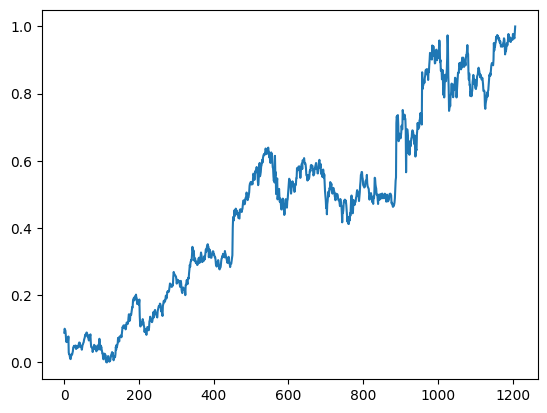

In [18]:
plt.plot(train_scaler)
plt.show()

## Create a data structure with 50 timesteps and 1 output

In [19]:
X_train = []
Y_train = []
timesteps = 50

In [20]:
for i in range(timesteps, len(train_scaler)):
    X_train.append(train_scaler[i - timesteps:i, 0]) # slicing on train_scaler array
    Y_train.append(train_scaler[i,0]) # taking next value from train_scaler as label

In [21]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [22]:
# reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [23]:
X_train.shape

(1158, 50, 1)

In [24]:
X_train[0]

array([[0.08886192],
       [0.10045847],
       [0.09768454],
       [0.0948143 ],
       [0.08267838],
       [0.06661273],
       [0.06062182],
       [0.06801896],
       [0.0632609 ],
       [0.06875096],
       [0.06360764],
       [0.07740022],
       [0.02897211],
       [0.02463785],
       [0.02494606],
       [0.01648944],
       [0.01117275],
       [0.01001695],
       [0.01700955],
       [0.02174834],
       [0.02361689],
       [0.02353984],
       [0.02910695],
       [0.03326784],
       [0.04492218],
       [0.04634767],
       [0.04960317],
       [0.04563492],
       [0.04813916],
       [0.04914085],
       [0.05047003],
       [0.04076129],
       [0.04284173],
       [0.04178225],
       [0.04954538],
       [0.04478733],
       [0.04511481],
       [0.0443828 ],
       [0.04765757],
       [0.0559023 ],
       [0.05942749],
       [0.05917707],
       [0.05767453],
       [0.04578903],
       [0.0467522 ],
       [0.0476961 ],
       [0.04569271],
       [0.038

In [25]:
Y_train[0]

0.05399522268454304

# Create And Training RNN model

In [26]:
# Import Keras model and RNN Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

In [27]:
# Initialising the RNN
regressor = Sequential()

# Add the first RNN layer and Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Second RNN layer and Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Third RNN layer and Dropout regularisation
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))

# Fourth RNN layer and Dropout regularisation
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))

# Add the output layer
regressor.add(Dense(units = 1))

In [28]:
# Compiling the RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error")

In [29]:
# Fitting the RNN to the training set
regressor.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
37/37 [==============================] - 5s 29ms/step - loss: 0.4082
Epoch 2/100
37/37 [==============================] - 1s 29ms/step - loss: 0.2697
Epoch 3/100
37/37 [==============================] - 1s 29ms/step - loss: 0.2062
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.1543
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.1354
Epoch 6/100
37/37 [==============================] - 1s 23ms/step - loss: 0.0962
Epoch 7/100
37/37 [==============================] - 1s 21ms/step - loss: 0.0877
Epoch 8/100
37/37 [==============================] - 1s 21ms/step - loss: 0.0653
Epoch 9/100
37/37 [==============================] - 1s 21ms/step - loss: 0.0663
Epoch 10/100
37/37 [==============================] - 1s 21ms/step - loss: 0.0529
Epoch 11/100
37/37 [==============================] - 1s 22ms/step - loss: 0.0505
Epoch 12/100
37/37 [==============================] - 1s 22ms/step - loss: 0.0404
Epoch 13/100
37/37 [=====

## Predictions And Visualising RNN Model

Prepare the test dataset:

In [30]:
inputs = data_set[len(data_set) - len(test) - timesteps:]
inputs = scaler.transform(inputs)

In [31]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i - timesteps:i, 0])

In [32]:
X_test_rnn = np.array(X_test)
X_test_rnn = np.reshape(X_test_rnn, (X_test_rnn.shape[0], X_test_rnn.shape[1], 1))

In [33]:
predicted_stock_price = regressor.predict(X_test_rnn)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

2/2 [==============================] - 0s 7ms/step


Visualize the result of the test dataset:

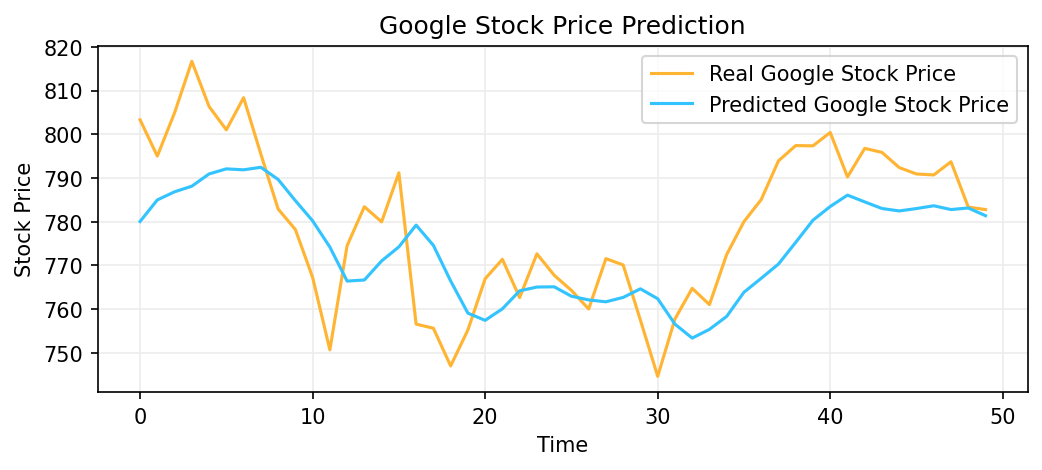

In [34]:
# visualising the results
plt.figure(figsize=(8,3), dpi=150)
plt.plot(test, color = "#FFB533", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "#33C4FF", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid(color='#ECECEC')
plt.legend(loc='upper right')
plt.show()

# Long Short Term Memory(LSTM)

## Prepare Data

Prepare trainX dataset for LSTM model. I just change its shape of X_train

In [35]:
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [36]:
# Import Library For LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

## Create the LSTM model

In [37]:
model = Sequential()
model.add(LSTM(10, input_shape = (1, timesteps)))
model.add(Dense(1))

In [38]:
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [39]:
model.fit(trainX, Y_train, epochs = 100, batch_size = 1)

Epoch 1/100
1158/1158 [==============================] - 3s 1ms/step - loss: 0.0082
Epoch 2/100
1158/1158 [==============================] - 2s 1ms/step - loss: 0.0018
Epoch 3/100
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 4/100
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 5/100
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0011
Epoch 6/100
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 7/100
1158/1158 [==============================] - 2s 2ms/step - loss: 0.0010
Epoch 8/100
1158/1158 [==============================] - 2s 2ms/step - loss: 9.2079e-04
Epoch 9/100
1158/1158 [==============================] - 2s 2ms/step - loss: 8.3260e-04
Epoch 10/100
1158/1158 [==============================] - 2s 2ms/step - loss: 8.6393e-04
Epoch 11/100
1158/1158 [==============================] - 2s 2ms/step - loss: 7.8394e-04
Epoch 12/100
1158/1158 [==============================] - 

KeyboardInterrupt: 

## Predictions And Visualising LSTM Model

In [ ]:
# Prepare test dataset
testX = np.array(X_test)
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

# Predict with testX
predict_lstm = model.predict(testX)
predict_lstm = scaler.inverse_transform(predict_lstm)

Visualize the result on the test dataset:

In [ ]:
# visualising the results
plt.figure(figsize=(8,3), dpi=150)
plt.plot(test, color = "#FFB533", label = "Real Google Stock Price")
plt.plot(predict_lstm, color = "#33C4FF", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid(color='#ECECEC')
plt.legend()
plt.show()

# EXERCISE
Add following [Callbacks](https://keras.io/api/callbacks/) to the models:
1. EarlyStopping
2. ModelCheckpoint
3. TensorBoard